**Notebook for Milestone 4**

In [127]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ML imports


In [128]:
#Load data
users = pd.read_csv('./../data/full_calcularis_users.csv')
events = pd.read_csv('./../data/full_calcularis_events.csv')
subtasks = pd.read_csv('./../data/full_calcularis_subtasks.csv')

print('Users: {}, Events: {}, Subtasks: {}'.format(len(users), len(events), len(subtasks)))

Users: 64932, Events: 2185200, Subtasks: 3502884


**Clean up data**. This includes:
    - *Add Items*

In [129]:
print(users.columns)
print(events.columns)
print(subtasks.columns)

Index(['user_id', 'learning_time_ms', 'logged_in_time_ms', 'language',
       'country', 'start', 'end'],
      dtype='object')
Index(['event_id', 'user_id', 'mode', 'game_name', 'learning_time_ms',
       'subtasks', 'number_range', 'start', 'end', 'skill_id', 'type'],
      dtype='object')
Index(['subtask_id', 'event_id', 'user_id', 'aim', 'answer', 'answerMode',
       'availableNumbers', 'correct', 'correctAnswerObject', 'correctNumber',
       'destination', 'distance', 'hasProperResult', 'interval', 'lowerBound',
       'maxHeight', 'minHeight', 'mode', 'multiplier', 'number',
       'numberRepresentations', 'numberToMultiply', 'numbers', 'operandA',
       'operandB', 'operator', 'range', 'representation', 'representations',
       'result', 'solution', 'solutionRepresentation', 'solveMode', 'source',
       'speed', 'startPosition', 'subtask_finished_timestamp', 'target',
       'timeoutInSeconds', 'timeoutInSteps', 'type', 'upperBound', 'step',
       'orderIndependent', 'divi

In [130]:
#types involve "['task' 'TRAINING_SELECTOR' 'ZOO' 'OVERVIEW' 'HELP' 'SHOP', 'ATTENTION_BOOSTER' 'GAME_START_PAUSE']"
#we are only interesting in "task" type for the wheel-spinning.
tasks = events[events.type == "task"]
print(len(tasks))
print(tasks.head(1))
print(tasks.game_name.nunique())
print(tasks.game_name.unique())

2153208
   event_id  user_id    mode   game_name  learning_time_ms  \
0         1        2  NORMAL  Subitizing           13094.0   

                                            subtasks number_range  \
0  [{'hasProperResult': True, 'range': 'R10', 'co...          R10   

                      start                       end  skill_id  type  
0  2020-08-20T07:13:50.876Z  2020-08-20T07:14:30.108Z       1.0  task  
29
['Subitizing' 'Conversion' 'Landing' 'Calculator' 'Comparison' 'Order'
 'Distance' 'Jump backwards' 'Calculator: Division' 'Secret Number'
 'Plus-minus' 'Series' 'Estimation on Number Line' 'Estimation'
 'Calculator: Multiplication' 'Shelf: random height'
 'Write as multiplication' 'Scale: Decomposition' 'Completion' 'Sliderule'
 'Scale: Subtraction' 'Scale: Subtraction by Tens and Ones' 'Difference'
 'Scale: Composition' 'Shelf: Jump Ahead' 'Scale: Conversion'
 'Calculator: Multiplication with ?' 'Shelf: given height' 'Distribution']


Calcularis has 29 different games. The question is, if each game is a different "skill" or if some are the same skill? We would need to categorize the games into the respective skills, but the problem is that we can only see 10 games in the demo version.

676878
382693
234261
177282
106111
103700
99174
89100
86825
78873


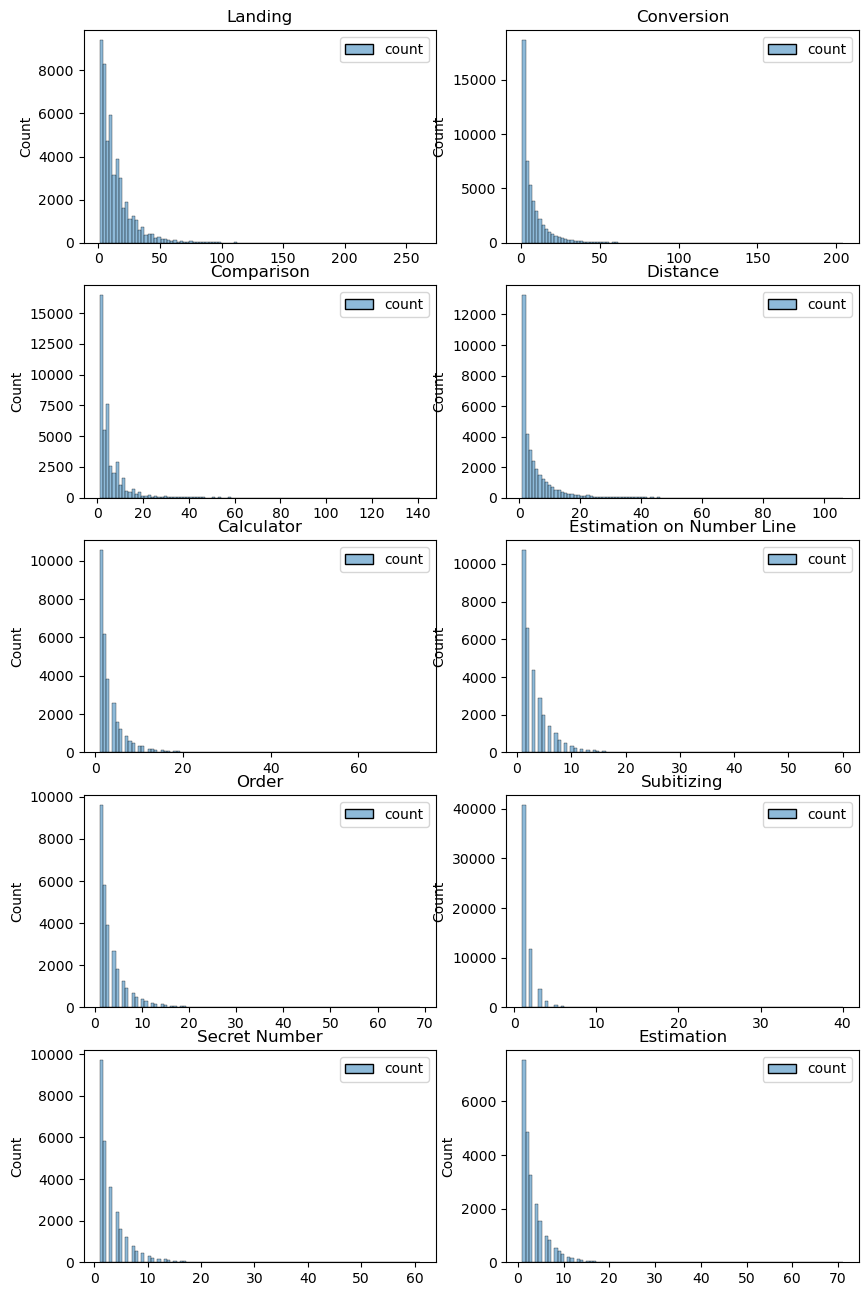

In [131]:
#Test how many tasks students solved in general of which type (to find proper threshold

#find out which games get played the most often:
#games = tasks[['user_id', 'game_name']].groupby(['game_name']).size().sort_values(ascending=False)
#top_10 = games.head(10)
#We work only on the 10 most played games (still 94,5% of the data)
top_10 = ['Landing', 'Conversion', 'Comparison', 'Distance', 'Calculator',
          'Estimation on Number Line','Order', 'Subitizing', 'Secret Number', 'Estimation']

tasks = tasks[tasks['game_name'].isin(top_10)] #94.5% of the data

#plot distribution of game_types played by users
fig, axs = plt.subplots(5,2,figsize=(10,16))
for i, game_type in enumerate(top_10):
    t = tasks[tasks['game_name'] == game_type][['user_id', 'game_name']]
    print(len(t))
    t = t.groupby(['user_id']).count()
    t.columns = ['count']
    sns.histplot(data=t, bins = 100, ax=axs[i // 2, i % 2]).set(title=game_type)
    
#A lot of students have less then 10 games played for a certain game_type.

    
    



In [132]:
#Attempt to create a timeseries dataframe for just one skill yet (Landing)
skill = 'Landing'
THRES_HOLD = 10
landing = tasks[tasks['game_name'] == skill]
#filter out all students who have less then THRES_HOLD "Practice Opportunities"
print("Total instances of Landing event: " +  str(len(landing)))
users_count = landing[['user_id', 'game_name']].groupby(['user_id']).count()
users_count.columns = ['count']
print("Users who performed the landing event:" + str(len(users_count)))
users_ten = users_count[users_count['count'] >= THRES_HOLD].index.to_numpy()

#print(users_ten)
print("Users who performed at least 10 landing events:" + str(len(users_ten))) #about 1/2 of users
landing_ten = landing[landing['user_id'].isin(users_ten)]

Total instances of Landing event: 676878
Users who performed the landing event:49397
Users who performed at least 10 landing events:24804


In [228]:
#filtering not really necessary for initial timeseries creation.
#dataframe "landing": includes all the instances of events of the type "Landing" from all students
#for ease of coding, initially only take some relevant columns:
#also only consider first 100 users, as otherwise it takes too long

print(landing.columns)

landing.head(2)
relevant = landing[['user_id', 'game_name', 'start','event_id']]
relevant = relevant[relevant['user_id'] <= 100]
print(len(landing))
print(len(relevant))

for index, row in relevant.iterrows():
    user = row['user_id']
    start = row['start']
    event = row['event_id']
    game_name = row['game_name']
    #Set the "practice opportunity" field
    prior_events = relevant[(relevant['user_id'] == user) & (relevant['start'] < start)]
    relevant.loc[index,'PO'] = int(len(prior_events))
    #Set the "correct" field
    event_subtasks = subtasks[subtasks['event_id'] == event].head()['correct']
    relevant.loc[index, 'correct'] = 1 if event_subtasks.values[0] else 0
    #Set the "correct response count" field
    relevant.loc[index, 'CRC'] = relevant[(relevant['user_id'] == user) & (relevant['start'] < start)]['correct'].sum()
    
for index, row in relevant.iterrows():
    #Set the "Correct response in a row count" field
    c = row['correct']
    if row['PO'] == 0:
        relevant.loc[index,'CRRC'] = c
    else:
        if c == 1:
            prior_val = relevant[(relevant['user_id'] == row['user_id']) & \
                            (relevant['game_name'] == row['game_name']) & \
                            (relevant['PO'] == row['PO'] - 1)].head()['CRRC'].values[0]
            relevant.loc[index,'CRRC'] = 1 + prior_val
        else:
            relevant.loc[index,'CRRC'] = 0
    
    
    
relevant = relevant.reset_index()
relevant.head(10)

#assuming that every task event only has one subtask!
#assuming that every task event only has one subtask!
#assuming that every task event only has one subtask!
#assuming that every task event only has one subtask!
#and therefore that if the correct field in that subtask is true -> event/task was correctly solved!
#TODO: verify this




Index(['event_id', 'user_id', 'mode', 'game_name', 'learning_time_ms',
       'subtasks', 'number_range', 'start', 'end', 'skill_id', 'type'],
      dtype='object')
676878
855


,index,user_id,game_name,start,event_id,PO,correct,CRC,CRRC
0,2,2,Landing,2020-08-24T07:02:59.855Z,4,0.0,1.0,0.0,1.0
1,3,2,Landing,2020-08-26T06:47:21.504Z,5,1.0,1.0,1.0,2.0
2,6,2,Landing,2020-08-31T06:52:10.097Z,9,2.0,1.0,2.0,3.0
3,9,2,Landing,2020-09-07T06:43:35.101Z,12,3.0,1.0,3.0,4.0
4,10,2,Landing,2020-09-09T07:08:21.657Z,13,4.0,1.0,4.0,5.0
5,11,2,Landing,2020-09-11T07:19:13.651Z,14,5.0,0.0,5.0,5.0
6,12,2,Landing,2020-09-14T07:15:42.563Z,15,6.0,1.0,5.0,6.0
7,15,2,Landing,2020-09-17T07:29:01.812Z,21,7.0,0.0,6.0,6.0
8,17,2,Landing,2020-09-21T06:43:51.387Z,23,8.0,0.0,6.0,6.0
9,21,2,Landing,2020-09-25T06:54:01.107Z,27,9.0,0.0,6.0,6.0


**Create table with selected features**:
- *per student/skill pair*:
    - Correct response count
    - Correct response in a row count
    - Expected mean response time z-score
    - <s> Prior problem count with hint request
    - <s> prior problem count with at least 5 hint request
- *per student*:
    - Prior problem count fast correct
    - Prior problem count normal correct
    - Prior problem count slow correct
    - Prior problem count fast incorrect
    - Prior problem count normal incorrect
    - Prior problem count slow incorrect
    - <s> Prior problem count with hint request in a row 
    - <s> Prior problem count with at least 5 hint requests in a row 
- *per student/skill pair (I think?)*
    - Prior problem count
    - Skill ID


**Add "wheel-spinning" column to DataFrame applying our definition of wheel-spinning:**
- *Three in a row*
- *Based on BLK*
- *other?*

**Predict wheelspinning using e.g. Logistic Regression, compare result to labels**